<h1><center>Face detection and emotion recognition</center></h1>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d gti-upm/leapgestrecog

kaggle.json
100% 2.13G/2.13G [00:25<00:00, 37.4MB/s]
100% 2.13G/2.13G [00:25<00:00, 89.6MB/s]


In [2]:
!unzip -q /content/leapgestrecog.zip -d /content/ds

Загрузим все необходимые библиотеки и начнем:

In [25]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#import torch.nn.functional as F
#from torchvision.datasets import ImageFolder
#import torchvision
#import torchvision.transforms as tt
#from torchvision.utils import make_grid


#import time
#from torch.autograd import Variable


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Словарь меток классов

In [6]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('/content/ds/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 3,
 '02_l': 0,
 '03_fist': 6,
 '04_fist_moved': 4,
 '05_thumb': 2,
 '06_index': 7,
 '07_ok': 5,
 '08_palm_moved': 9,
 '09_c': 1,
 '10_down': 8}

Подготовка данных для обучения в виде numpy-массивов

In [10]:
x_data = []
y_data = []
datacount = 0
for i in range(0, 10):
    for j in os.listdir('/content/ds/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir('/content/ds/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                img = Image.open('/content/ds/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                img = img.resize((160, 60))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

Демонстрация обучающих изображений и меток

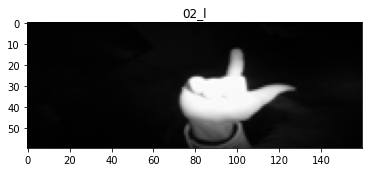

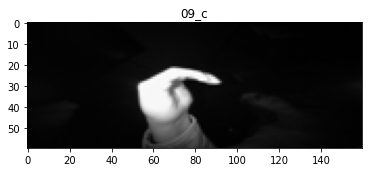

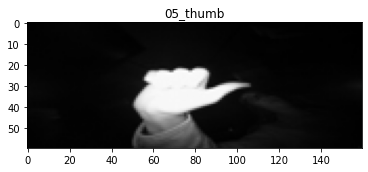

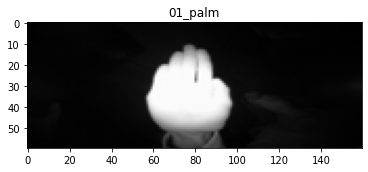

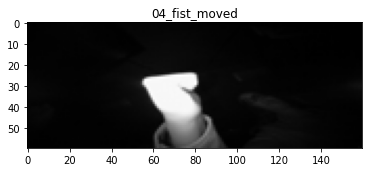

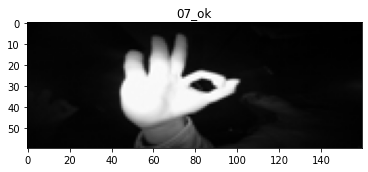

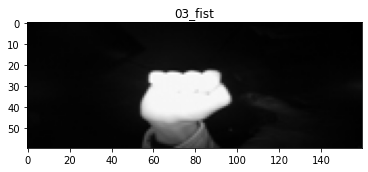

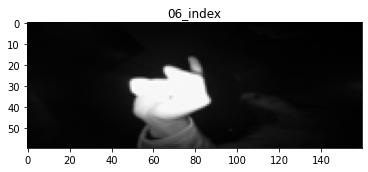

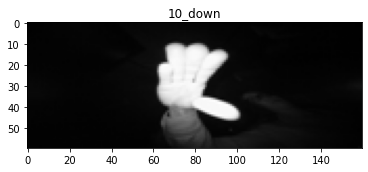

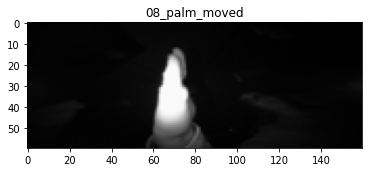

In [12]:
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :], cmap='gray')
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

Пайплайн данных

In [17]:
class Hand_Dataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data


    def __len__(self):
        return len(self.x_data) 
    
    
    def __getitem__(self, idx):
        item = torch.Tensor(self.x_data[idx].reshape(-1,60,160))
        
        # one-hot encoding
        #label = np.zeros(10)
        #label[self.y_data[idx, 0]] = 1
        #label = torch.Tensor(label)
        
        # без one-hot
        label = self.y_data[idx,0]

        return (item, label) 

In [18]:
dataset = Hand_Dataset(x_data, y_data)

In [19]:
train_loader = DataLoader(dataset, batch_size = 10, shuffle=True)

In [21]:
i,j = next(iter(train_loader))
print('Image shape:', i.size())
print('Label shape:', j.size())
print('Label:', j)

Image shape: torch.Size([10, 1, 60, 160])
Label shape: torch.Size([10])
Label: tensor([1, 0, 2, 6, 3, 7, 3, 7, 8, 8])


Модель сверточной сети для распознавания жестов

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*2*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)   

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64*2*8)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


net = Net().to(device)

Функция потерь и оптимизатор

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [36]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item() 

    print(f'Epoch: {epoch:2d}, loss: {running_loss:.4f}')  

print('Training is finished!')

Epoch:  0, loss: 275.5813
Epoch:  1, loss: 76.5964
Epoch:  2, loss: 7.8202
Epoch:  3, loss: 62.2833
Epoch:  4, loss: 32.1031
Epoch:  5, loss: 58.6237
Epoch:  6, loss: 14.1846
Epoch:  7, loss: 58.1448
Epoch:  8, loss: 59.8394
Epoch:  9, loss: 33.4272
Training is finished!


Проверка предсказаний на изображениях датасета

torch.Size([3, 1, 60, 160])
GroundTruth:    04_fist_moved            02_l        05_thumb
Predicted:      04_fist_moved            02_l        05_thumb


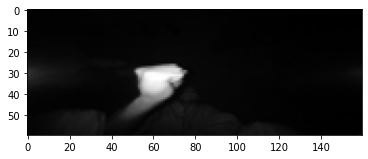

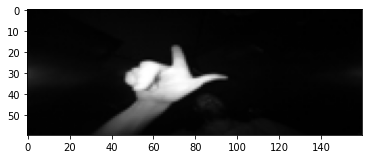

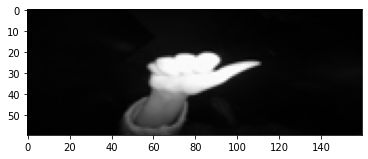

In [37]:
N=3

test_loader = DataLoader(dataset, batch_size = N, shuffle=True)

data_iter = iter(test_loader)
images, labels = data_iter.next()
print(images.size())
net = net.to('cpu')
outputs = net(images)
for i in range(N):
  plt.figure()
  plt.imshow(images[i].numpy()[0], cmap='gray')
print('GroundTruth: ', ' '.join('%15s' % reverselookup[labels[j].item()] 
                                for j in range(N)))
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%15s' % reverselookup[predicted[j].item()]
                              for j in range(N)))

Проверка предсказаний на моих фото с веб-камеры

04_fist_moved


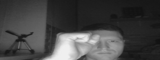

In [71]:
img = Image.open('/content/cam.png').convert('L')
img = img.resize((160, 60))
img_t = torch.Tensor(np.array(img))
img_t = img_t.unsqueeze(0).unsqueeze(0)
net = net.to('cpu')
output = net(img_t)
_, predicted = torch.max(output, 1)
print(reverselookup[predicted[0].item()])
img

02_l


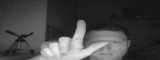

In [70]:
img = Image.open('/content/cam11.png').convert('L')
img = img.resize((160, 60))
img_t = torch.Tensor(np.array(img))
img_t = img_t.unsqueeze(0).unsqueeze(0)
net = net.to('cpu')
output = net(img_t)
_, predicted = torch.max(output, 1)
print(reverselookup[predicted[0].item()])
img

05_thumb


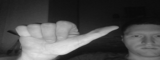

In [69]:
img = Image.open('/content/cam12.png').convert('L')
img = img.resize((160, 60))
img_t = torch.Tensor(np.array(img))
img_t = img_t.unsqueeze(0).unsqueeze(0)
net = net.to('cpu')
output = net(img_t)
_, predicted = torch.max(output, 1)
print(reverselookup[predicted[0].item()])
img

Вроде работает. Работает хорошо только при выключенном в комнате свете.

Сохраним модель.

In [72]:
torch.save(net, '/content/hand_model.pth')